In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from pipeline.acquisition import load_sisfall_data
from pipeline.preprocessing import change_activity_duration
from pipeline.preprocessing import change_activity_sampling
from pipeline.feature_extraction import extract_features
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
dataset_folder = "datasets/SisFall_dataset/"
models_output_folder = 'models/'
uma_dataset_folder = "datasets/output_uma"
combined_dataset_folder = "datasets/combined_dataset"


INCLUDE_GYROSCOPE = False

if INCLUDE_GYROSCOPE:
    sensors =  [0, 1, 2, 3, 4, 5]
else:
    sensors = [0, 1, 2]

should_load_sisfall_data = False

ignored_subjects = []
duration = 12000
frequency = 200

should_save_models = True

In [4]:
if should_load_sisfall_data is True:
    raw_sisfall_dataset = load_sisfall_data(dataset_folder, ignored_subjects, sensors)

    raw_sisfall_dataset.to_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")
else:
    raw_sisfall_dataset = pd.read_pickle(f"{combined_dataset_folder}/sisfall_raw_dataset.pkl")

In [36]:
raw_sisfall_dataset

,subject,activity,trial,data
0,SA01,D01,R01,acc_x acc_y ...
1,SA01,D01,R01,acc_x acc_y ...
2,SA01,D01,R01,acc_x acc_y ...
3,SA01,D01,R01,acc_x acc_y ...
4,SA01,D01,R01,acc_x acc_y ...
...,...,...,...,...
5100,SE15,D17,R01,acc_x acc_y ...
5101,SE15,D17,R02,acc_x acc_y ...
5102,SE15,D17,R03,acc_x acc_y ...
5103,SE15,D17,R04,acc_x acc_y ...


In [6]:
import os
import re

def uma_search_csv_files(directory, activities_of_interest=None):
    csv_files = []
    for current_folder, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                if activities_of_interest is not None:
                    for activity in activities_of_interest:
                        # Use regex to match exact activity number
                        pattern = rf"{activity}(?=Trial|_|\.csv)"
                        if re.search(pattern, file):
                            full_path = os.path.join(current_folder, file)
                            csv_files.append(full_path)
                            break
                else:
                    full_path = os.path.join(current_folder, file)
                    csv_files.append(full_path)
    return csv_files


uma_files = uma_search_csv_files(directory=uma_dataset_folder, activities_of_interest=['Activity1','Activity2','Activity8','Activity13','Activity14','Activity15'])

combined_uma_df = pd.concat([pd.read_csv(file) for file in uma_files], ignore_index=True)

combined_uma_df.rename(columns={
    'Accelerometer: x-axis (g)': 'acc_x',
    'Accelerometer: y-axis (g)': 'acc_y',
    'Accelerometer: z-axis (g)': 'acc_z',
    'Gyroscope: x-axis (rad/s)': 'gyro_x',
    'Gyroscope: y-axis (rad/s)': 'gyro_y',
    'Gyroscope: z-axis (rad/s)': 'gyro_z'
}, inplace=True)

# Display the shape of the combined dataframe
combined_uma_df[700:710]

,TimeStamp,acc_x,acc_y,acc_z,Subject,Activity,Trial,Tag
700,7.337,0.133057,0.416016,0.917480,15,14,3,0
701,7.343,0.14209,0.4104,0.921387,15,14,3,0
702,7.348,0.14209,0.4104,0.921387,15,14,3,0
703,7.383,0.137695,0.414551,0.915039,15,14,3,0
704,7.432,0.132812,0.406738,0.918213,15,14,3,0
705,7.578,0.140869,0.412842,0.916260,15,14,3,0
706,7.581,0.140869,0.412842,0.916260,15,14,3,0
707,7.627,0.144775,0.407715,0.921875,15,14,3,0
708,7.630,0.140381,0.468262,0.917480,15,14,3,0
709,7.773,0.138184,0.46582,0.918457,15,14,3,0


In [18]:
grouped_data = []

# Sort by Subject, Activity, Trial, and TimeStamp to ensure proper ordering
combined_df_sorted = combined_uma_df.sort_values(['Subject', 'Activity', 'Trial', 'TimeStamp']).reset_index(drop=True)

current_group = []
current_subject = None
current_activity = None
current_trial = None
group_id = 0

for idx, row in combined_df_sorted.iterrows():
    # Check if we're starting a new session (different subject/activity/trial)
    if (current_subject != row['Subject'] or 
        current_activity != row['Activity'] or 
        current_trial != row['Trial']):
        
        # Save the previous group if it exists
        if current_group:
            group_df = pd.DataFrame(current_group)

            if INCLUDE_GYROSCOPE:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
            else:
                sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]

            timestamps = group_df['TimeStamp']
            
            group_row = {
                'subject': current_subject,
                'activity': f"D{current_activity}",
                'trial': current_trial,
                # 'group_id': group_id,
                'data': sensor_data,
            }
            grouped_data.append(group_row)
            group_id += 1
        
        # Start new group
        current_group = [row.to_dict()]
        current_subject = row['Subject']
        current_activity = row['Activity']
        current_trial = row['Trial']
    else:
        # Check if timestamp has reset/jumped backwards (indicating new data segment)
        if current_group:
            last_timestamp = current_group[-1]['TimeStamp']
            current_timestamp = row['TimeStamp']
            
            # If current timestamp is less than or equal to previous (reset occurred)
            if current_timestamp <= last_timestamp:
                # Save the current group
                group_df = pd.DataFrame(current_group)
                if INCLUDE_GYROSCOPE:
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
                else:   
                    sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
                timestamps = group_df['TimeStamp']
                
                group_row = {
                    'subject': current_subject,
                    'activity': f"D{current_activity}",
                    'trial': current_trial,
                    'data': sensor_data,
                }
                grouped_data.append(group_row)
                group_id += 1
                
                # Start new group with current row
                current_group = [row.to_dict()]
            else:
                # Continue adding to current group
                current_group.append(row.to_dict())
        else:
            current_group.append(row.to_dict())

# Don't forget the last group
if current_group:
    group_df = pd.DataFrame(current_group)
    if INCLUDE_GYROSCOPE:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
    else:
        sensor_data = group_df[['acc_x', 'acc_y', 'acc_z']]
    timestamps = group_df['TimeStamp']
    
    group_row = {
        'subject': current_subject,
        'activity': f"D{current_activity}",
        'trial': current_trial,
        'data': sensor_data,
    }
    grouped_data.append(group_row)

# Convert to DataFrame
uma_raw_dataset = pd.DataFrame(grouped_data)
uma_raw_dataset


,subject,activity,trial,data
0,1,D1,1,acc_x acc_y acc_z 0 -0.74023...
1,1,D1,2,acc_x acc_y acc_z 0 -0.76416...
2,1,D1,3,acc_x acc_y acc_z 0 -0.75732...
3,1,D8,1,acc_x acc_y acc_z 0 -0.58740...
4,1,D8,2,acc_x acc_y acc_z 0 -0.81396...
...,...,...,...,...
334,19,D15,2,acc_x acc_y acc_z 0 -1.02294...
335,19,D15,3,acc_x acc_y acc_z 0 -1.37255...
336,19,D15,4,acc_x acc_y acc_z 0 -0.92089...
337,19,D15,5,acc_x acc_y acc_z 0 -0.90795...


In [19]:
# import itertools
# import numpy as np


# def extract_features(data, with_magnitude):
#     """
#     Extracts various features from the time and frequency domains from a given sample of activity. Also constructs
#     features by combining the raw data.

#     :param data: the data from the activity
#     :param with_magnitude: calculate the magnitude of the sensors
#     :return: list with all the features extracted from the activity
#     """
    
#     # Make a copy to avoid modifying original data
#     data = data.copy()
    
#     # Clean and ensure all data is numeric
#     for col in data.columns:
#         # Convert to string first, then replace any concatenated values
#         data[col] = data[col].astype(str)
#         # If values are concatenated, this won't work well, so let's handle it
#         data[col] = pd.to_numeric(data[col], errors='coerce')
    
#     # Fill any NaN values with 0
#     data = data.fillna(0)
    
#     # Check if we still have any non-numeric data
#     if not data.select_dtypes(include=[np.number]).shape[1] == data.shape[1]:
#         print("Warning: Non-numeric data detected, attempting to clean...")
#         # Additional cleaning if needed
#         for col in data.columns:
#             if data[col].dtype == 'object':
#                 print(f"Column {col} contains non-numeric data")
#                 data[col] = 0  # Set problematic columns to 0
    
#     # Calculates the acceleration and rotation magnitudes
#     if with_magnitude:
#         for i in range(0, data.shape[1], 3):
#             if i + 2 < data.shape[1]:  # Ensure we have 3 columns
#                 # Select the 3-axis slice
#                 slice_ = data.iloc[:, i:i+3]
                
#                 # Compute magnitude
#                 magnitude = np.linalg.norm(slice_, axis=1)
                
#                 # Generate magnitude column name
#                 name = 'mag_' + data.columns[i][0:len(data.columns[i])-2]
                
#                 # Assign magnitude column
#                 data[name] = magnitude

#     # Creates features vector name
#     names = ['mean', 'var', 'std', 'median', 'max', 'min', 'ptp', 'centile25', 'centile75']
#     columns = list('_'.join(n) for n in itertools.product(names, data.columns.tolist()))

#     # Time domain features
#     features = np.mean(data, axis=0)
#     features = np.hstack((features, np.var(data, axis=0)))
#     features = np.hstack((features, np.std(data, axis=0)))
#     features = np.hstack((features, np.median(data, axis=0)))
#     features = np.hstack((features, np.max(data, axis=0)))
#     features = np.hstack((features, np.min(data, axis=0)))
#     features = np.hstack((features, np.ptp(np.asarray(data), axis=0)))
#     features = np.hstack((features, np.percentile(data, 25, axis=0)))
#     features = np.hstack((features, np.percentile(data, 75, axis=0)))

#     # Creates a DataFrame
#     features = pd.DataFrame([features], columns=columns)
#     return features

# # Extract features from uma_dataset
# print("Processing UMA dataset...")
# feature_list = []
# labels = []
# subjects = []
# activity_codes = []

# for i in uma_raw_dataset.index:
#     # Get data from each row
#     data = uma_raw_dataset['data'][i]
    
#     # Extract features
#     features_uma = extract_features(data, True)
    
#     # Store results
#     feature_list.append(features_uma)
#     subjects.append(uma_raw_dataset['subject'][i])
#     activity_codes.append(uma_raw_dataset['activity'][i])

# # Combine into final dataset
# uma_raw_dataset = pd.concat(feature_list, ignore_index=True)
# uma_raw_dataset['subject'] = subjects
# uma_raw_dataset['activity_code'] = activity_codes




# ALL_ACTIVITY_MAPPING = {
#     'D01': 'adl',
#     'D02': 'adl',
#     'D03': 'adl',
#     'D04': 'adl',
#     'D05': 'adl',
#     'D06': 'adl',
#     'D07': 'adl',
#     'D08': 'adl',
#     'D09': 'adl',
#     'D10': 'adl',
#     'D11': 'adl',
#     'D12': 'adl',
#     'D13': 'fall',
#     'D14': 'fall',
#     'D15': 'fall',
#     'D16': 'adl',
#     'D17': 'adl',
#     'D18': 'adl',
#     'D19': 'adl',
#     'F01': 'fall',
#     'F02': 'fall',
#     'F03': 'fall',
#     'F04': 'fall',
#     'F05': 'fall',
#     'F06': 'fall',
#     'F07': 'fall',
#     'F08': 'fall',
#     'F09': 'fall',
#     'F10': 'fall',
#     'F11': 'fall',
#     'F12': 'fall',
#     'F13': 'fall',
#     'F14': 'fall',
#     'F15': 'fall',
#     'D1': 'adl',
#     'D8': 'adl',
#     'D9': 'adl',
#     'D2': 'adl',
#     'D4': 'adl',
#     'D7': 'adl',
#     'D5': 'adl',
#     'D6': 'adl'
# }

# activity_codes = uma_raw_dataset['activity_code'] 
# y_labels = activity_codes.map(ALL_ACTIVITY_MAPPING)

# y_labels
# # X_uma = uma_raw_dataset.drop(columns=['activity_code', 'subject'])
# # X_uma
uma_raw_dataset

,subject,activity,trial,data
0,1,D1,1,acc_x acc_y acc_z 0 -0.74023...
1,1,D1,2,acc_x acc_y acc_z 0 -0.76416...
2,1,D1,3,acc_x acc_y acc_z 0 -0.75732...
3,1,D8,1,acc_x acc_y acc_z 0 -0.58740...
4,1,D8,2,acc_x acc_y acc_z 0 -0.81396...
...,...,...,...,...
334,19,D15,2,acc_x acc_y acc_z 0 -1.02294...
335,19,D15,3,acc_x acc_y acc_z 0 -1.37255...
336,19,D15,4,acc_x acc_y acc_z 0 -0.92089...
337,19,D15,5,acc_x acc_y acc_z 0 -0.90795...


In [20]:
raw_sisfall_dataset

,subject,activity,trial,data
0,SA01,D01,R01,acc_x acc_y ...
1,SA01,D01,R01,acc_x acc_y ...
2,SA01,D01,R01,acc_x acc_y ...
3,SA01,D01,R01,acc_x acc_y ...
4,SA01,D01,R01,acc_x acc_y ...
...,...,...,...,...
5100,SE15,D17,R01,acc_x acc_y ...
5101,SE15,D17,R02,acc_x acc_y ...
5102,SE15,D17,R03,acc_x acc_y ...
5103,SE15,D17,R04,acc_x acc_y ...


In [21]:
combined_sisfall_and_uma_dataset_raw = pd.concat([raw_sisfall_dataset, uma_raw_dataset], ignore_index=True)

In [22]:
combined_sisfall_and_uma_dataset_raw

,subject,activity,trial,data
0,SA01,D01,R01,acc_x acc_y ...
1,SA01,D01,R01,acc_x acc_y ...
2,SA01,D01,R01,acc_x acc_y ...
3,SA01,D01,R01,acc_x acc_y ...
4,SA01,D01,R01,acc_x acc_y ...
...,...,...,...,...
5439,19,D15,2,acc_x acc_y acc_z 0 -1.02294...
5440,19,D15,3,acc_x acc_y acc_z 0 -1.37255...
5441,19,D15,4,acc_x acc_y acc_z 0 -0.92089...
5442,19,D15,5,acc_x acc_y acc_z 0 -0.90795...


In [ ]:
ACTIVITY_CLASSES = {
    'walking': ['D01', 'D02','D1'],  
    'jogging': ['D03', 'D04',"D2"],
    'fall': ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', "F11","F12","F13", "F14","F15", 'D13', 'D14', 'D15'],
    'sitting': ['D11',"D12", "D13", 'D8'],
}

# Create code to class mapping
CODE_TO_CLASS = {}
for class_name, codes in ACTIVITY_CLASSES.items():
    for code in codes:
        CODE_TO_CLASS[code] = class_name


    
def prepare_sisfall_dataset(raw_dataset, CODE_TO_CLASS, duration, frequency):

    filtered_indices = []
    for i in raw_dataset.index:
        activity_code = raw_dataset['activity'][i]
        if activity_code in CODE_TO_CLASS:
            filtered_indices.append(i)

    
    feature_list = []
    labels = []
    subjects = []
    activity_codes = []

    for i in filtered_indices:

        # Get data and preprocess
        data = raw_dataset['data'][i]
        data = change_activity_duration(data, duration)

        # data = change_activity_sampling(data, frequency)
        
        # Extract features
        features = extract_features(data, True)
        
        # Get class label
        activity_code = raw_dataset['activity'][i]
        class_label = CODE_TO_CLASS[activity_code]
        
        # Store results
        feature_list.append(features)
        labels.append(class_label)
        subjects.append(raw_dataset['subject'][i])
        activity_codes.append(activity_code)

    # Combine into final dataset
    prepared_dataset = pd.concat(feature_list, ignore_index=True)
    prepared_dataset['class'] = labels
    prepared_dataset['subject'] = subjects
    prepared_dataset['activity_code'] = activity_codes

    print(f"Final dataset shape: {prepared_dataset.shape}")
    print("\nClass distribution:")
    print(prepared_dataset['class'].value_counts())
    
    return prepared_dataset

# prepared_dataset = prepare_dataset(raw_sisfall_dataset, CODE_TO_CLASS, duration, frequency)
prepared_dataset = prepare_sisfall_dataset(combined_sisfall_and_uma_dataset_raw, CODE_TO_CLASS, duration, frequency)

Final dataset shape: (3767, 39)

Class distribution:
class
fall       2308
sitting     626
walking     435
jogging     398
Name: count, dtype: int64


In [28]:
prepared_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class,subject,activity_code
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking,SA01,D01
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking,SA01,D01
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking,SA01,D01
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking,SA01,D01
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking,SA01,D01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall,19,D15
3763,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall,19,D15
3764,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall,19,D15
3765,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall,19,D15


In [29]:
prepared_dataset.drop(columns=['activity_code','subject'], inplace=True)

In [ ]:
# uma_raw_dataset['class'] = uma_raw_dataset['activity_code'].map(ALL_ACTIVITY_MAPPING)
# uma_raw_dataset.drop(columns=['activity_code', 'subject'], inplace=True)

In [30]:
prepared_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,walking
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,walking
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,walking
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,walking
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,walking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall
3763,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall
3764,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall
3765,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall


In [ ]:
# final_combined_dataset = pd.concat([prepared_dataset, uma_raw_dataset], ignore_index=True)

In [ ]:
# final_combined_dataset

,mean_acc_x,mean_acc_y,mean_acc_z,mean_mag_acc,var_acc_x,var_acc_y,var_acc_z,var_mag_acc,std_acc_x,std_acc_y,...,ptp_mag_acc,centile25_acc_x,centile25_acc_y,centile25_acc_z,centile25_mag_acc,centile75_acc_x,centile75_acc_y,centile75_acc_z,centile75_mag_acc,class
0,0.008047,-1.002363,-0.116230,1.027459,0.014411,0.024467,0.022692,0.024205,0.120046,0.156419,...,0.716120,-0.058594,-1.093750,-0.207031,0.912239,0.074219,-0.894531,-0.003906,1.112180,adl
1,0.032422,-1.010781,-0.153926,1.047548,0.013144,0.046032,0.032962,0.041203,0.114648,0.214550,...,0.874586,-0.043945,-1.148438,-0.242188,0.890982,0.071289,-0.862305,-0.041992,1.162675,adl
2,0.086914,-0.996895,-0.131387,1.036573,0.018921,0.049386,0.031944,0.044382,0.137555,0.222231,...,0.997805,0.034180,-1.070312,-0.223633,0.902399,0.137695,-0.880859,-0.012695,1.122104,adl
3,0.071191,-0.990645,-0.109707,1.027136,0.020926,0.052222,0.032249,0.048870,0.144657,0.228522,...,0.948117,0.000000,-1.055664,-0.184570,0.866589,0.122070,-0.842773,-0.006836,1.124120,adl
4,0.019824,-1.038809,-0.144199,1.083208,0.024211,0.066873,0.043796,0.061850,0.155598,0.258598,...,1.067569,-0.114258,-1.180664,-0.247070,0.909638,0.127930,-0.870117,-0.035156,1.203087,adl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5439,-0.198070,0.358674,0.618709,1.052136,0.152059,0.229037,0.209130,0.033916,0.389947,0.478578,...,2.061288,-0.272461,-0.112061,0.579102,0.971959,-0.060791,0.700684,0.864258,1.090969,fall
5440,-0.144246,0.619491,-0.081711,1.126797,0.184675,1.139300,0.496442,0.961999,0.429738,1.067380,...,9.651395,-0.020020,0.783691,-0.081299,0.935022,-0.008301,0.937256,0.035400,1.004671,fall
5441,-0.619123,-0.596731,0.389268,1.068791,0.053604,0.128418,0.136904,0.067544,0.231526,0.358355,...,3.522952,-0.708740,-0.774841,0.178711,0.986254,-0.533203,-0.464844,0.564209,1.084290,fall
5442,-0.144801,0.470989,-0.601326,0.959936,0.084430,0.114638,0.153182,0.035164,0.290569,0.338582,...,2.171418,-0.089111,0.479614,-0.769409,0.905493,-0.045898,0.631104,-0.670776,0.959350,fall


In [31]:
final_combined_dataset = prepared_dataset

In [32]:
from sklearn.model_selection import train_test_split


X_train,X_test = train_test_split(final_combined_dataset, 
    test_size=0.2, 
    stratify=final_combined_dataset['class'], 
    random_state=42
)

y_train = X_train['class']
y_test = X_test['class']

final_X_train = X_train.drop(columns=['class'])
final_X_test = X_test.drop(columns=['class'])



In [33]:
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(final_X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(final_X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(final_X_train, y_train)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(final_X_train, y_train)


lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(final_X_train, y_train)


if should_save_models:
    joblib.dump(svm, f"{models_output_folder}/svm_model_combined_adl.pkl")
    joblib.dump(rf, f"{models_output_folder}/rf_model_combined_adl.pkl")
    joblib.dump(knn, f"{models_output_folder}/knn_model_combined_adl.pkl")
    joblib.dump(dt, f"{models_output_folder}/dt_model_combined_adl.pkl")
    joblib.dump(lr, f"{models_output_folder}/lr_model_combined_adl.pkl")


Model: SVC
Classification Report:
              precision    recall  f1-score   support

        fall       0.91      0.98      0.94       462
     jogging       1.00      0.94      0.97        80
     sitting       0.90      0.75      0.82       125
     walking       0.91      0.84      0.87        87

    accuracy                           0.92       754
   macro avg       0.93      0.88      0.90       754
weighted avg       0.92      0.92      0.92       754

Confusion Matrix:
Accuracy: 0.9204



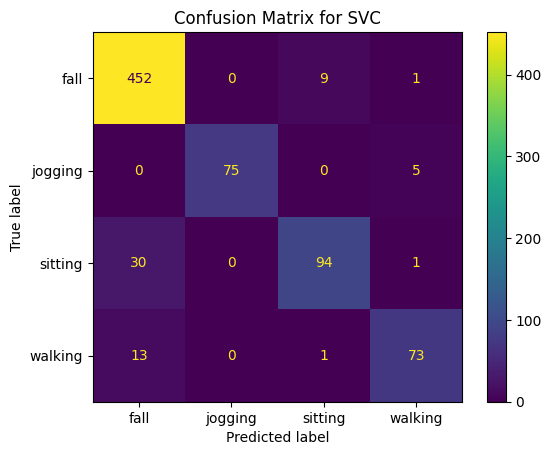

Model: RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.95      1.00      0.98       462
     jogging       1.00      0.95      0.97        80
     sitting       0.97      0.86      0.91       125
     walking       0.95      0.93      0.94        87

    accuracy                           0.96       754
   macro avg       0.97      0.93      0.95       754
weighted avg       0.96      0.96      0.96       754

Confusion Matrix:
Accuracy: 0.9615



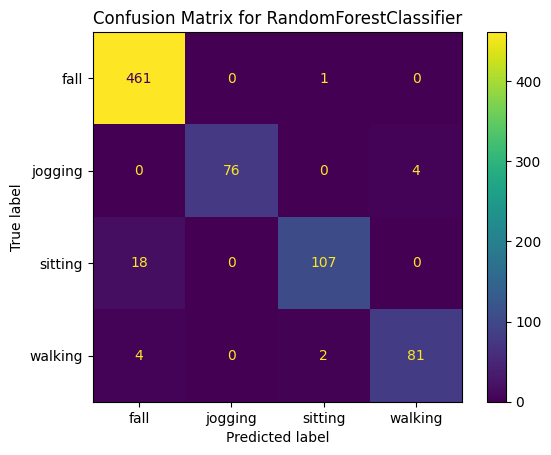

Model: KNeighborsClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.94      0.99      0.96       462
     jogging       1.00      0.94      0.97        80
     sitting       0.91      0.73      0.81       125
     walking       0.88      0.93      0.91        87

    accuracy                           0.93       754
   macro avg       0.93      0.90      0.91       754
weighted avg       0.93      0.93      0.93       754

Confusion Matrix:
Accuracy: 0.9324



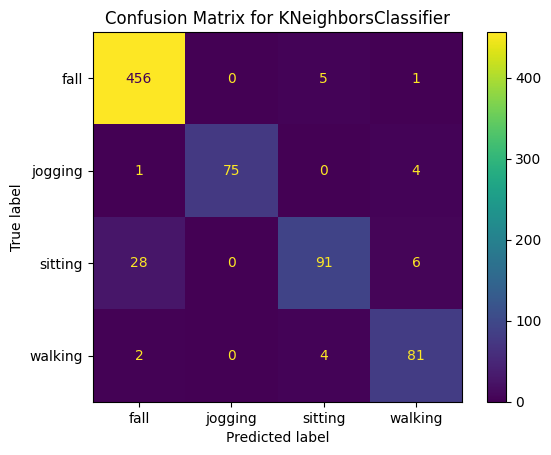

Model: DecisionTreeClassifier
Classification Report:
              precision    recall  f1-score   support

        fall       0.96      0.95      0.96       462
     jogging       0.94      0.96      0.95        80
     sitting       0.85      0.86      0.86       125
     walking       0.96      0.93      0.95        87

    accuracy                           0.94       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.94      0.94      0.94       754

Confusion Matrix:
Accuracy: 0.9377



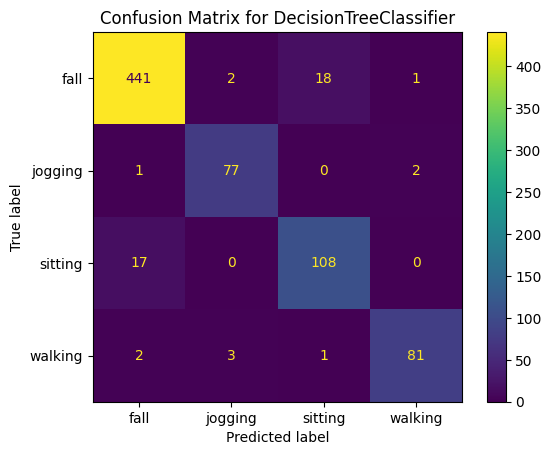

Model: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

        fall       0.94      0.94      0.94       462
     jogging       1.00      0.95      0.97        80
     sitting       0.82      0.78      0.80       125
     walking       0.85      0.95      0.90        87

    accuracy                           0.92       754
   macro avg       0.90      0.90      0.90       754
weighted avg       0.92      0.92      0.91       754

Confusion Matrix:
Accuracy: 0.9151



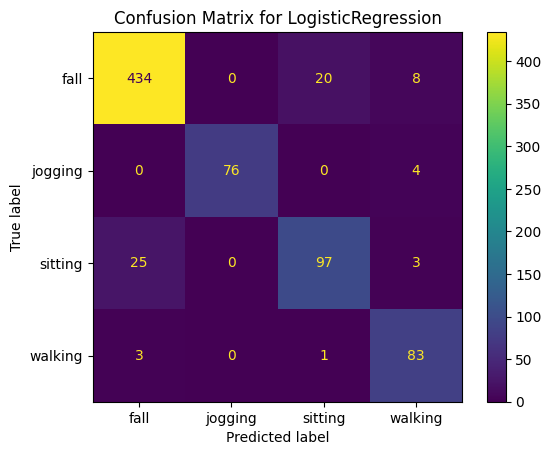

In [34]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()

# Evaluate all models
evaluate_model(svm, final_X_test, y_test)
evaluate_model(rf, final_X_test, y_test)
evaluate_model(knn, final_X_test, y_test)
evaluate_model(dt, final_X_test, y_test)
evaluate_model(lr, final_X_test, y_test)